# Analysis of tweets on education in ChatGPT
## Bi-directional LSTM with RNN Architecture for 3 classes (5 iteration)
Neutral - 0
Positive - 1
Negative - 2


---


The data set : https://drive.google.com/file/d/1Lw3UNB5FCUQqm1Otk7EYBvpDyIHM7ALi/view?usp=drive_link

---


Orgin: https://www.kaggle.com/datasets/nutrientaxis/chatgpt-and-education-tweets-dataset?select=ChatGPT_Education_Tweets_Dataset.csv

In [1]:
! pip install transformers

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional
from tensorflow.keras.initializers import Constant
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [7]:
%cd /mydrive/dataset/

/content/gdrive/My Drive/dataset


In [8]:
df_data = pd.read_csv("ChatGPT_Education_Tweets_Dataset.csv")

In [9]:
df_data['sentiment'] = df_data['sentiment'].replace({'neutral': 0 ,'positive': 1, 'negative': 2})

In [10]:
target_samples = 44000
neutral_tweets = df_data[df_data['sentiment'] == 0].sample(n=target_samples, random_state=42)
positive_tweets = df_data[df_data['sentiment'] == 1].sample(n=target_samples, random_state=42)
negative_tweets = df_data[df_data['sentiment'] == 2].sample(n=target_samples, random_state=42)


balanced_df = pd.concat([neutral_tweets, positive_tweets, negative_tweets], ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42)

In [11]:
print("Number of neutral tweets:", balanced_df[balanced_df['sentiment'] == 0].shape[0])
print("Number of positive tweets:", balanced_df[balanced_df['sentiment'] == 1].shape[0])
print("Number of negative tweets:", balanced_df[balanced_df['sentiment'] == 2].shape[0])

Number of neutral tweets: 44000
Number of positive tweets: 44000
Number of negative tweets: 44000


In [12]:
balanced_df

Unnamed: 0             tweet_id  \
42745        94657  1625111072599580672   
15736       209848  1651260049774501889   
39650       156588  1639954318869553153   
64365       201544  1649215372694790145   
11616       225274  1655050120143212545   
...            ...                  ...   
110268       10102  1601690142820868096   
119879      126868  1633596476046581761   
103694      216503  1653067227535482882   
131932       67856  1619371541153857536   
121958      171996  1642881104284725248   

                                            original_text  \
42745   i just published how to reduce the negative im...   
15736   just realised that i have to submit a research...   
39650   @epsilontheory extension of the “move the anal...   
64365   but #chatgpt is otherwise quite useful. it hel...   
11616   read #adjunctnation today:  why you should emb...   
...                                                   ...   
110268  i wrote a thread on november 24th about how mu...   
119879  protip: tell chatgpt to act like an autistic t...   
103694  how’s my professor gonna be walking round clas...   
131932  public education is not job ready. why are we ...   
121958  i thought chatgpt was doing well as my unpaid ...   

                                                     text  sentiment  \
42745   i just published how to reduce the negative im...          0   
15736   just realised that i have to submit a research...          0   
39650   username extension of the move the analystasso...          0   
64365   but chatgpt is otherwise quite useful it helps...          1   
11616   read adjunctnation today why you should embrac...          0   
...                                                   ...        ...   
110268  i wrote a thread on november 24th about how mu...          2   
119879  protip tell chatgpt to act like an autistic te...          2   
103694  hows my professor gonna be walking round class...          2   
131932  public education is not job ready why are we n...          2   
121958  i thought chatgpt was doing well as my unpaid ...          2   

                                        tasks      users  \
42745                                     NaN        NaN   
15736                                     NaN        NaN   
39650                                     NaN    company   
64365                                     NaN        NaN   
11616                                     NaN  classroom   
...                                       ...        ...   
110268                                    NaN        man   
119879                         write an essay        NaN   
103694                                    NaN        NaN   
131932                                    NaN    student   
121958  dutifully provided to the wrong paper        NaN   

                      technologies       organizations  \
42745   automation, impact, reduce                 RPA   
15736                          NaN                 NaN   
39650                          NaN  Friend, GPT, Bcode   
64365                          NaN                 NaN   
11616                          NaN           Classroom   
...                            ...                 ...   
110268                         NaN                 NaN   
119879                         NaN                 NaN   
103694                      laptop                 NaN   
131932                         NaN                 NaN   
121958                      google                 NaN   

                              competencies               job_profiles  
42745                                  NaN                        NaN  
15736                                  NaN                        NaN  
39650                                  NaN                        NaN  
64365                   work independently                        NaN  
11616                                  NaN                        NaN  
...                                    ... 

In [16]:
len(df_data)

236275

In [17]:
len(balanced_df)

132000

In [18]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'one', 'two','more','chatgpt','chat','gpt','gpt4','username','chatbot'])

In [19]:
def preprocess(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower() != 'mor']
    return ' '.join(filtered_words)

In [20]:
balanced_df['clean'] = balanced_df['text'].apply(preprocess)

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(balanced_df['clean'])
sequences = tokenizer.texts_to_sequences(balanced_df['clean'])
maxlen = 40
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

In [23]:
# Split data into train and test sets 80:20
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, balanced_df['sentiment'], test_size=0.2)

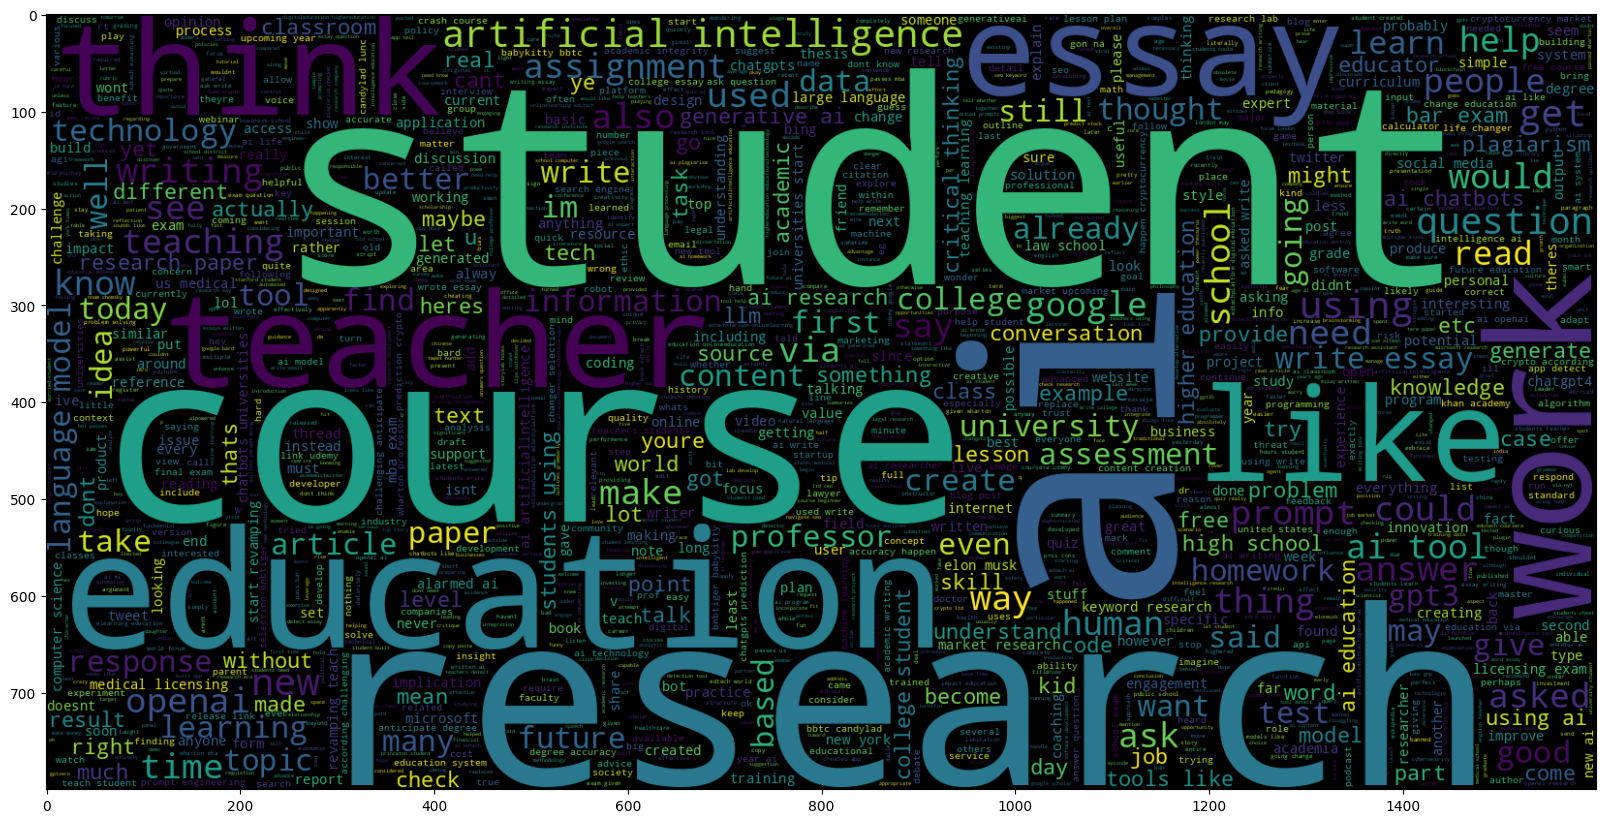

In [24]:
#Neutral sentiment
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(balanced_df[balanced_df.sentiment==0].clean))
plt.imshow(wc, interpolation = 'bilinear')

In [42]:
# Generate the WordCloud
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(balanced_df[balanced_df.sentiment == 0].clean))

# Get the top 10 words and their frequencies
top_words = wc.words_
top_words_sorted = sorted(top_words.items(), key=lambda item: item[1], reverse=True)
top_10_words_neutral = [word for word, freq in top_words_sorted[:10]]


In [39]:
print(", ".join(top_10_words_neutral))

ai, student, research, course, education, work, teacher, think, like, essay


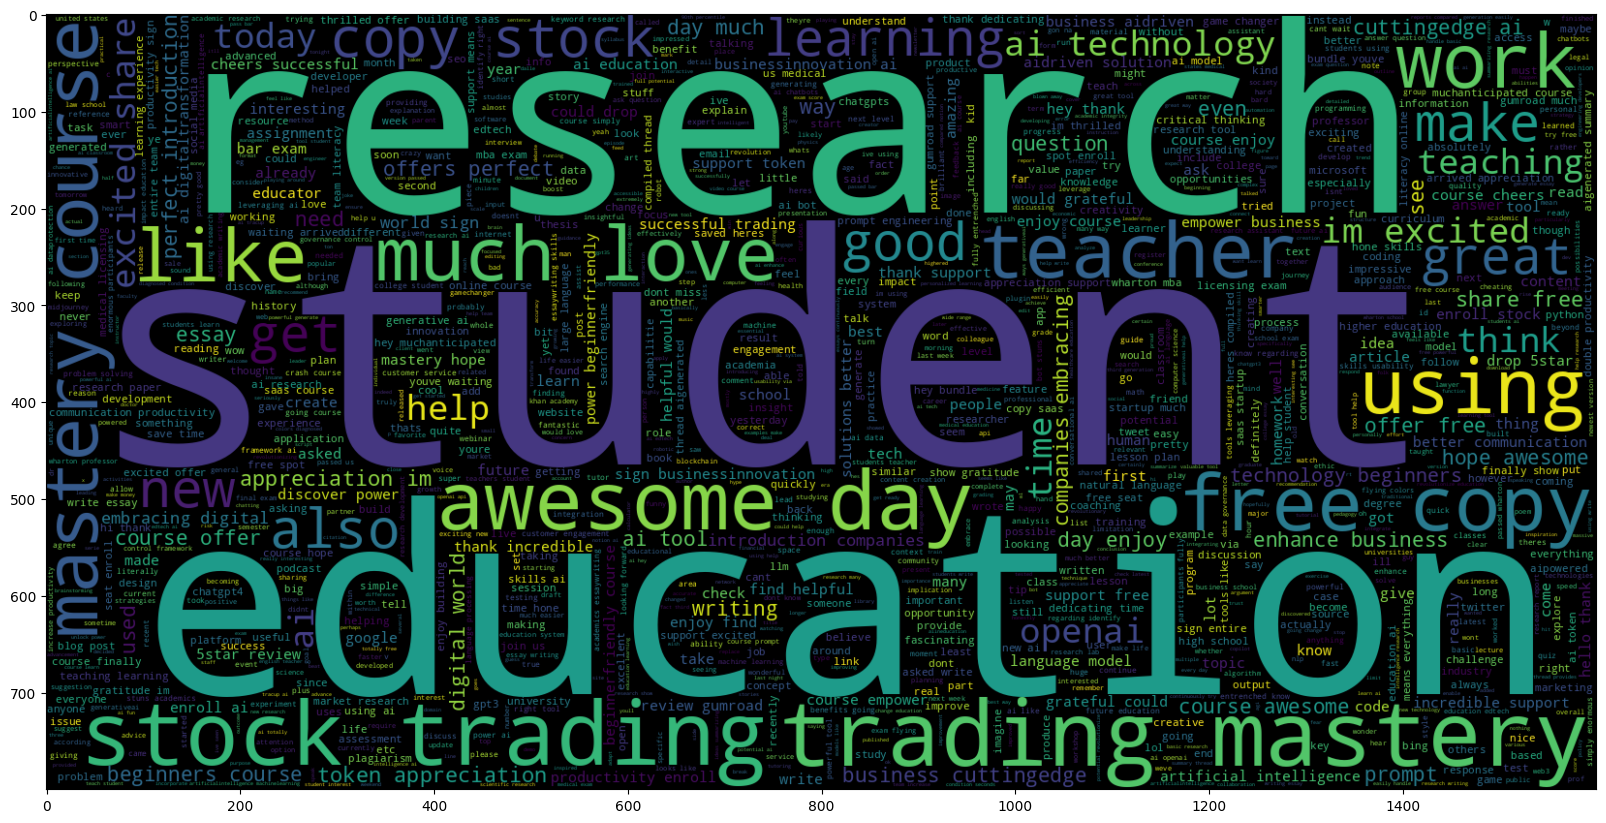

In [25]:
#positive sntiment
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(balanced_df[balanced_df.sentiment==1].clean))
plt.imshow(wc, interpolation = 'bilinear')

In [43]:
# Generate the WordCloud
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(balanced_df[balanced_df.sentiment == 1].clean))

# Get the top 10 words and their frequencies
top_words = wc.words_
top_words_sorted = sorted(top_words.items(), key=lambda item: item[1], reverse=True)
top_10_words_positive = [word for word, freq in top_words_sorted[:10]]


In [44]:
print(", ".join(top_10_words_positive))

student, education, research, trading mastery, stock trading, awesome day, free copy, teacher, work, using


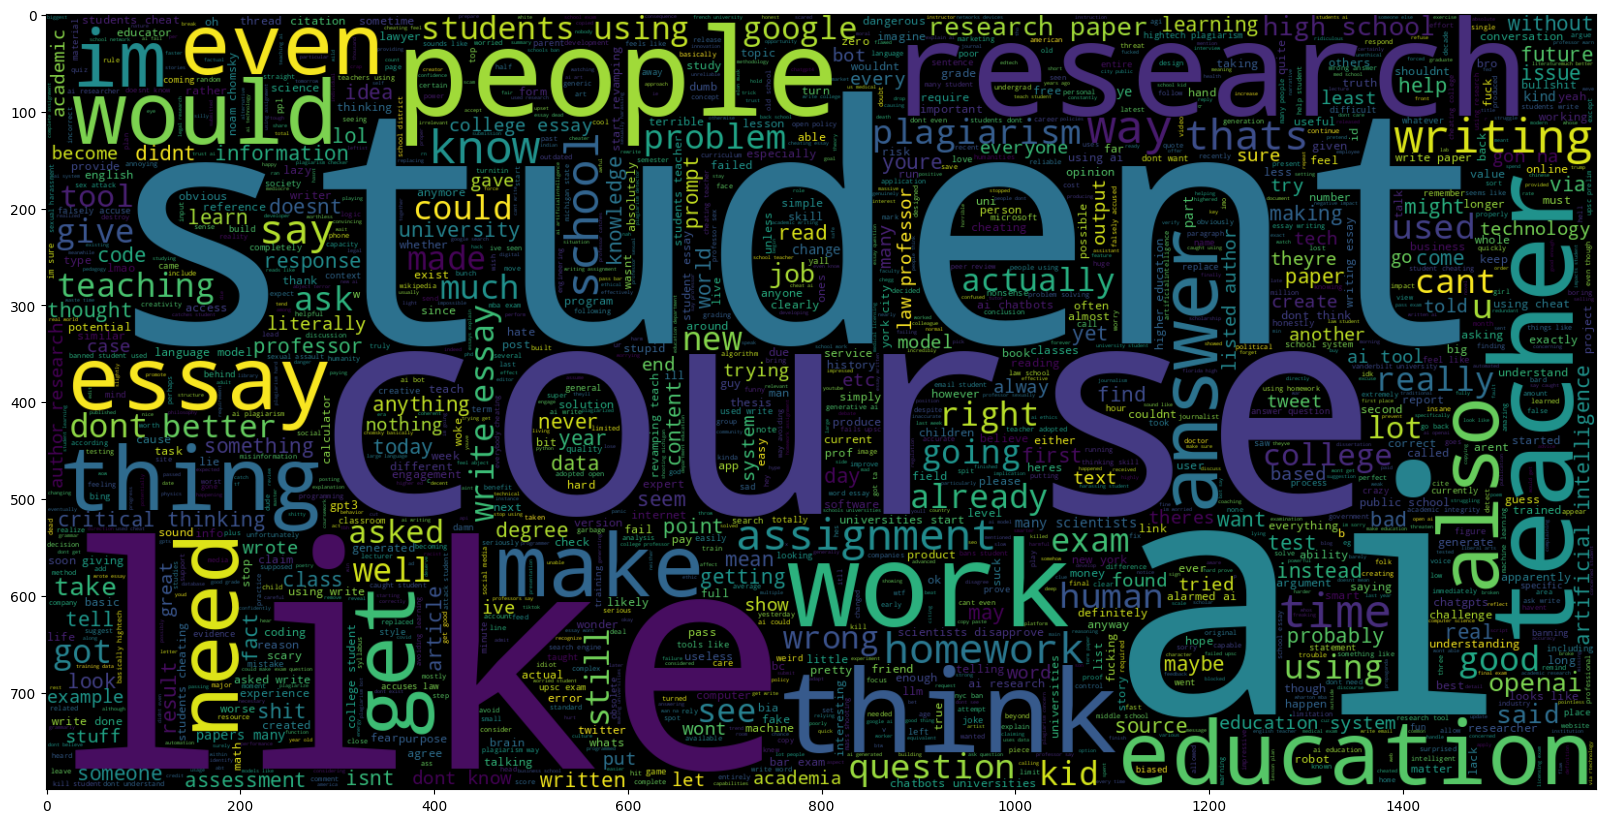

In [26]:
#negative sntiment
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(balanced_df[balanced_df.sentiment==2].clean))
plt.imshow(wc, interpolation = 'bilinear')

In [45]:
# Generate the WordCloud
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(balanced_df[balanced_df.sentiment == 2].clean))

# Get the top 10 words and their frequencies
top_words = wc.words_
top_words_sorted = sorted(top_words.items(), key=lambda item: item[1], reverse=True)
top_10_words_negative = [word for word, freq in top_words_sorted[:10]]

In [46]:
print(", ".join(top_10_words_negative))

ai, student, like, course, research, people, work, think, teacher, education


In [29]:
total_words = len(tokenizer.word_index) + 1

In [30]:
total_words

81298

In [31]:
# Create a multi-class LSTM model
model = Sequential()
model.add(Embedding(total_words, output_dim=128))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(3, activation='softmax'))  # Output layer with softmax for multi-class classification
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         10406144  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 10,670,083
Trainable params: 10,670,083
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Train the model
train_model = model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=5)

Epoch 1/5
1320/1320 [==============================] - 619s 469ms/step - loss: 0.6631 - acc: 0.7071 - val_loss: 0.5927 - val_acc: 0.7434
Epoch 2/5
1320/1320 [==============================] - 614s 465ms/step - loss: 0.4500 - acc: 0.8169 - val_loss: 0.6306 - val_acc: 0.7428
Epoch 3/5
1320/1320 [==============================] - 620s 470ms/step - loss: 0.3243 - acc: 0.8729 - val_loss: 0.6947 - val_acc: 0.7366
Epoch 4/5
1320/1320 [==============================] - 623s 472ms/step - loss: 0.2317 - acc: 0.9116 - val_loss: 0.8390 - val_acc: 0.7304
Epoch 5/5
1320/1320 [==============================] - 624s 473ms/step - loss: 0.1644 - acc: 0.9383 - val_loss: 1.0425 - val_acc: 0.7204


825/825 [==============================] - 44s 52ms/step
Model Accuracy: 0.7219318181818182
Classification Report:
               precision    recall  f1-score   support

     neutral       0.64      0.68      0.66      8888
    positive       0.77      0.74      0.76      8730
    negative       0.77      0.74      0.76      8782

    accuracy                           0.72     26400
   macro avg       0.73      0.72      0.72     26400
weighted avg       0.73      0.72      0.72     26400



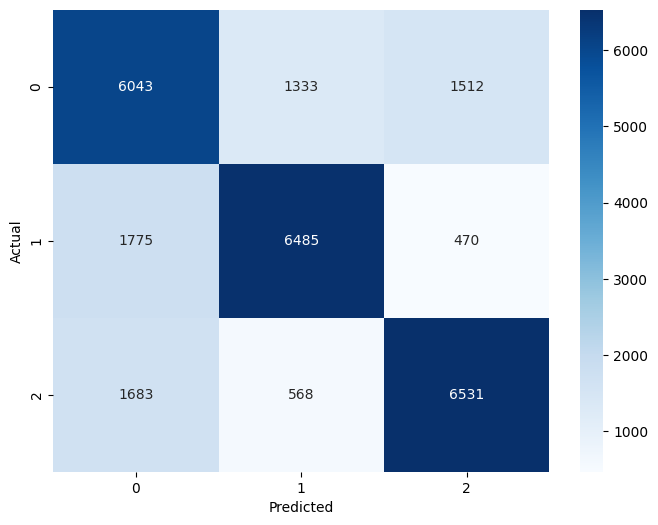

In [34]:
# Classification and Evaluation
predictions = model.predict(x_test)
classification = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, classification)
print("Model Accuracy:", accuracy)

report = classification_report(y_test, classification, target_names=["neutral", "positive", "negative"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test, classification)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


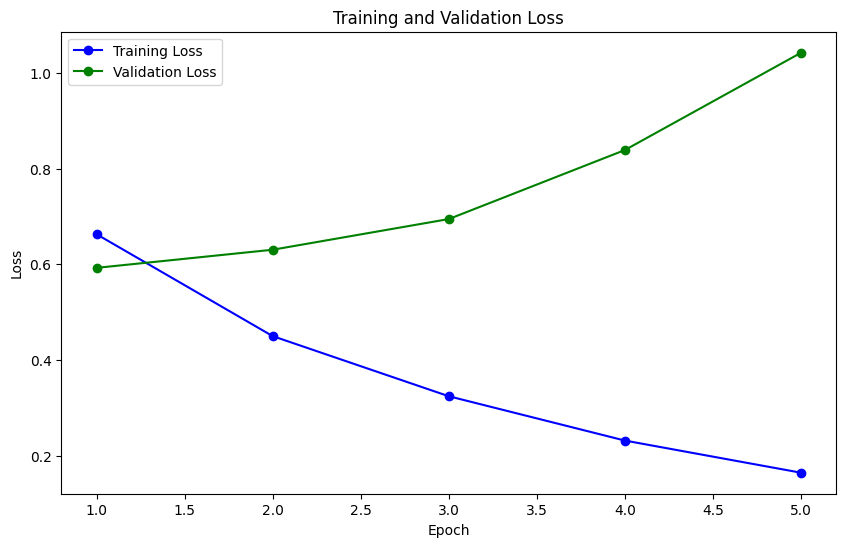

In [35]:
# Get the training and validation loss from the training history
train_loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
